# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm.auto as tqdm
%matplotlib widget

In [11]:
def grab(x):
    return x.detach().numpy()

# Brief ML primer

Let's quickly demonstrate how training looks in Pytorch. We will train a small neural network to model the function
$$
f(x) = \mathrm{sinc}(x) := \frac{\sin(\pi x)}{\pi x}
$$

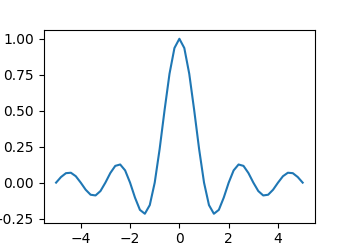

In [4]:
def target_fn(x):
    return torch.sinc(x)
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
xs = torch.linspace(-5, 5, steps=51)
ys = target_fn(xs)
ax.plot(grab(xs), grab(ys))
plt.show()

In [9]:
class ToyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x[:,None])[:,0]

In [20]:
def train_model():
    model = ToyModel()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    batch_size = 32
    hist = []
    for i in tqdm.tqdm(range(1000)):
        opt.zero_grad()
        x = torch.randn((batch_size,))
        y = target_fn(x)
        ymodel = model.forward(x)
        loss = ((y - ymodel)**2).mean()
        loss.backward()
        hist.append(grab(loss))
        opt.step()
    return dict(model=model, hist=np.stack(hist))
res = train_model()

  0%|          | 0/1000 [00:00<?, ?it/s]

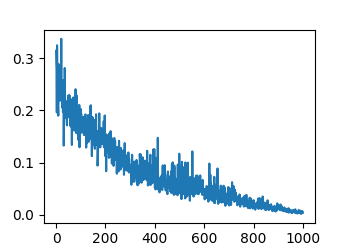

In [21]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
ax.plot(res['hist'])
plt.show()

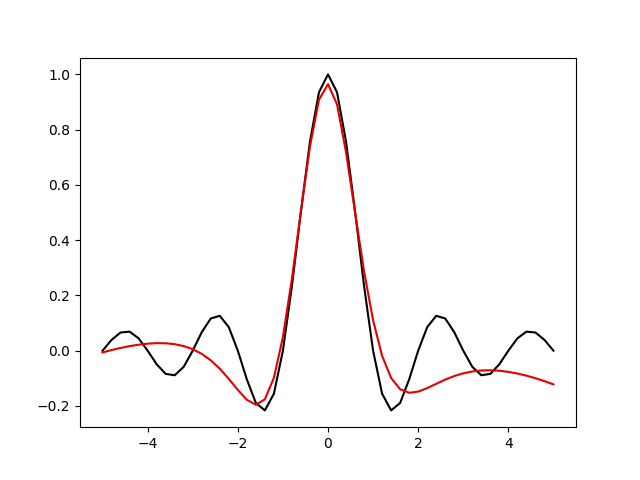

In [22]:
fig, ax = plt.subplots(1,1)
xs = torch.linspace(-5, 5, steps=51)
ys = target_fn(xs)
with torch.no_grad():
    model_ys = res['model'].forward(xs)
ax.plot(grab(xs), grab(ys), color='k')
ax.plot(grab(xs), grab(model_ys), color='xkcd:red')
plt.show()

# Target

To explore learned flows, we will use a standard 2D target, a **mixture of Gaussians**:
$$
p(x) = \frac{1}{\sqrt{2\pi}} \sum_i \sigma(\alpha)_i e^{-(x-\mu_i)^2/2}.
$$
Above, $\sigma(\alpha)_i := e^{\alpha_i} / \sum_j e^{\alpha_j}$ is the Softmax function, which maps a vector $\vec{\alpha}$ to positive-definite and normalized weights.

In [24]:
class MixtureOfGaussians:
    def __init__(self, mu, alpha):
        self.mu = mu
        self.alpha = alpha
        self.logw = torch.nn.functional.log_softmax(alpha, dim=0)
    def sample(self, batch_size):
        x = torch.randn((batch_size,2))
        i = np.arange(len(self.logw))
        inds = np.random.choice(i, size=batch_size, p=np.exp(grab(self.logw)))
        # this indexing trick extracts the full 2d vectors at inds (see below)
        return x + self.mu[inds[:,None], np.arange(2)]
    # TODO: implement sample() and log_prob()
    pass

In [ ]:
# this is an indexing trick that will be useful
a = np.arange(24).reshape(6, 4)
inds = np.array([1, 4, 3])
# this pulls rows "inds" out of a
extracted = a[inds[:,None], np.arange(4)]
print(f'{a=}')
print(' -> ')
print(f'{extracted=}')

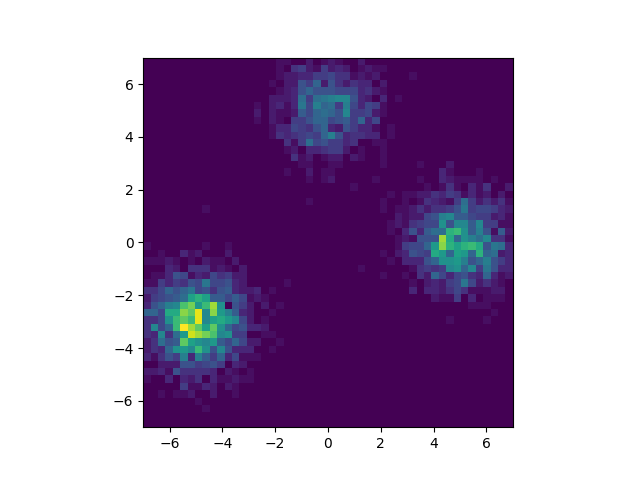

In [26]:
# some reasonable parameters for the MoG
mu = torch.tensor([
    [5., 0.],
    [0, 5.],
    [-5., -3.]
])
alpha = torch.tensor([0.5, 0.0, 0.8])
target = MixtureOfGaussians(mu, alpha)
x = grab(target.sample(4096))
fig, ax = plt.subplots(1,1)
bins = np.linspace(-7, 7, num=51)
ax.hist2d(x[:,0], x[:,1], bins=bins)
ax.set_aspect(1.0)
plt.show()
# TODO: draw samples and plot density

# Flow model

In [ ]:
class Velocity(torch.nn.Module):
    pass

From Lecture 1:

In [ ]:
def flow(x, velocity, *, n_step, tf=1.0, inverse=False):
    dt = tf/n_step
    ts = dt*torch.arange(n_step)
    logJ = torch.tensor(0.0)
    sign = 1
    if inverse:
        sign = -1
        ts = reversed(ts)
    for t in ts:
        # transport samples
        x = x + sign * dt * velocity.value(x, t)
        # estimate change of measure
        logJ = logJ + dt * velocity.div(x, t)
    return x, logJ

**Training option 1:** Reverse KL divergence between target and model.

In [ ]:
def train_model_rkl():
    pass
res_rkl = train_model_rkl()

In [ ]:
# TODO: plot loss history

In [ ]:
# TODO: plot model vs true samples

**Training option 2:** Forward KL using samples from target.

In [ ]:
def train_model_fkl():
    pass
res_fkl = train_model_fkl()